      fy    revenue        end  gross_profit  net_income  gross_margin_pct  \
9   2020   66378000 2020-12-31     461875000    66378000          6.958254   
10  2021  189580000 2021-12-31    1954187000   189580000         10.307981   
11  2022  430158000 2022-12-31    2277954000   430158000          5.295622   
12  2023  408375000 2023-12-31    2598711000   408375000          6.363541   
13  2024  633125000 2024-12-31    2753179000   633125000          4.348555   

    net_margin_pct  
9              1.0  
10             1.0  
11             1.0  
12             1.0  
13             1.0  


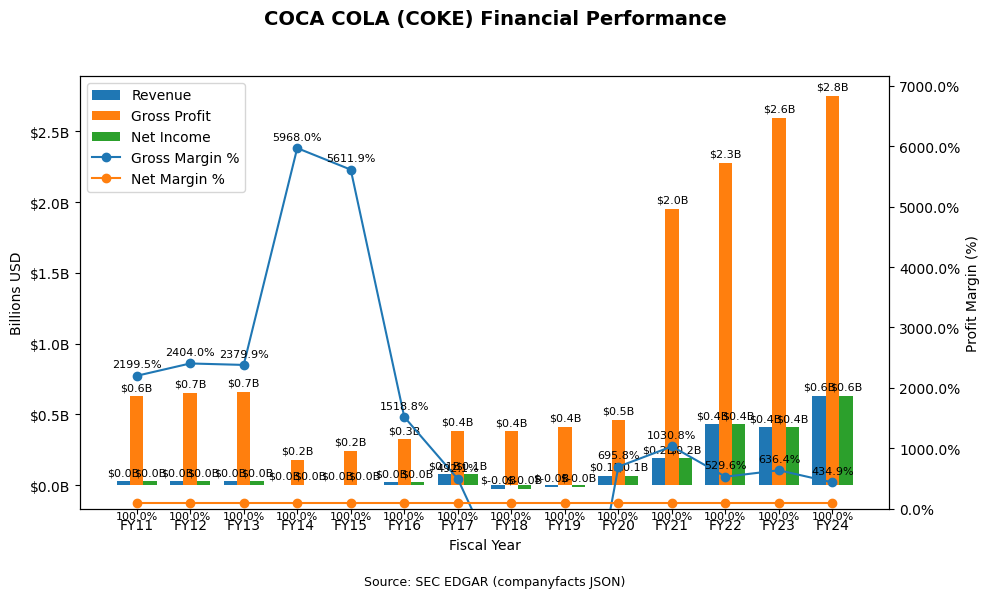

In [ ]:
# --- SEC EDGAR annual "sales" chart (bars + margin lines) ---
# Paste this whole block into your script.

import time
import json
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- CONFIG ----------
UA = {"User-Agent": "POLITICO / Giulia Petrilli gpetrilli@politico.eu"}
BASE = "https://data.sec.gov/api"

# Core tags
#REVENUE_TAG = "RevenueFromContractWithCustomerExcludingAssessedTax"  # ASC-606 "sales"
REVENUE_TAG = "NetIncomeLoss"
GROSS_PROFIT_TAG = "GrossProfit"
NET_INCOME_TAG = "NetIncomeLoss"

# ---------- UTIL / FETCH ----------
def load_ticker_map() -> Dict[str, str]:
    """Return {'APPL': '0000320193', ...} using SEC's official mapping."""
    url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    j = r.json()
    return {v["ticker"].upper(): f'{int(v["cik_str"]):010d}' for v in j.values()}

def company_concept(cik10: str, taxonomy: str, tag: str) -> dict:
    """Fetch one concept for one company from the SEC XBRL 'companyconcept' endpoint."""
    url = f"{BASE}/xbrl/companyconcept/CIK{cik10}/{taxonomy}/{tag}.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    return r.json()

def concept_to_df(j: dict, prefer_units=("USD", "USD$", "USD (in millions)")) -> pd.DataFrame:
    """Convert a companyconcept JSON to a tidy DataFrame of facts for one unit."""
    units = j.get("units", {})
    unit_key = None
    for u in prefer_units:
        if u in units:
            unit_key = u
            break
    if unit_key is None and units:
        unit_key = next(iter(units))
    rows = units.get(unit_key, [])
    if not rows:
        return pd.DataFrame(columns=["fy","fp","end","val","form","filed","accn"])
    df = pd.DataFrame(rows)
    for c in ("fy","fp","end","val","form","filed","accn"):
        if c not in df.columns: df[c] = pd.NA
    df["fy"] = pd.to_numeric(df["fy"], errors="coerce").astype("Int64")
    df["end"] = pd.to_datetime(df["end"], errors="coerce")
    df = df.sort_values(["end","fy"], na_position="last").reset_index(drop=True)
    return df[["fy","fp","end","val","form","filed","accn"]]

def _annual_series(df: pd.DataFrame, how: str = "prefer_fy") -> pd.DataFrame:
    """
    Build a fiscal-year series from a concept DF.
    Strategy:
      - If annual facts exist (fp == FY or CY), take the last-filed per FY.
      - Else, sum quarters (Q1..Q4) per FY as a fallback.
    Returns: columns [fy, end, value]
    """
    df = df.copy()
    df["fy"] = df["fy"].astype("Int64")
    annual_rows = df[df["fp"].str.upper().isin(["FY","CY"])]
    if not annual_rows.empty:
        a = (annual_rows.sort_values("end")
                          .groupby("fy", dropna=True)
                          .agg(value=("val","last"), end=("end","last"))
                          .reset_index())
        return a.dropna(subset=["fy"])
    # fallback: sum quarters
    q = df[df["fp"].str.upper().str.startswith("Q")]
    if q.empty:
        return pd.DataFrame(columns=["fy","end","value"])
    a = (q.sort_values("end")
           .groupby("fy", dropna=True)
           .agg(value=("val","sum"), end=("end","max"))
           .reset_index())
    return a.dropna(subset=["fy"])

def get_annual_financials(ticker: str) -> pd.DataFrame:
    """
    For a given ticker, fetch annual Revenue (ASC-606), Gross Profit, Net Income.
    Output columns: fy, end, revenue, gross_profit, net_income,
                    gross_margin_pct, net_margin_pct
    """
    tmap = load_ticker_map()
    tk = ticker.upper()
    if tk not in tmap:
        raise ValueError(f"Ticker {ticker} not in SEC mapping.")
    cik10 = tmap[tk]

    # Fetch concepts
    rev = concept_to_df(company_concept(cik10, "us-gaap", REVENUE_TAG))
    time.sleep(0.2)
    gp  = concept_to_df(company_concept(cik10, "us-gaap", GROSS_PROFIT_TAG))
    time.sleep(0.2)
    ni  = concept_to_df(company_concept(cik10, "us-gaap", NET_INCOME_TAG))

    # Build annual series per concept
    rev_a = _annual_series(rev).rename(columns={"value":"revenue"})
    gp_a  = _annual_series(gp).rename(columns={"value":"gross_profit"})
    ni_a  = _annual_series(ni).rename(columns={"value":"net_income"})

    # Outer-join on FY so we don't drop years missing one component
    df = rev_a.merge(gp_a[["fy","gross_profit"]], on="fy", how="outer") \
              .merge(ni_a[["fy","net_income"]], on="fy", how="outer")
    # choose an end date per FY (prefer revenue's end, else gp/ni)
    df = df.sort_values("fy").reset_index(drop=True)
    if "end_x" in df.columns or "end_y" in df.columns:
        df["end"] = df.filter(regex=r"^end").bfill(axis=1).iloc[:,0]
        df = df.drop(columns=[c for c in df.columns if c.startswith("end_")])
    df["gross_margin_pct"] = df["gross_profit"] / df["revenue"]
    df["net_margin_pct"]   = df["net_income"]  / df["revenue"]
    return df.dropna(subset=["fy"]).sort_values("fy").reset_index(drop=True)

# ---------- FORMATTING ----------
def _fmt_billions(x, pos):
    if np.isnan(x): return ""
    return f"${x/1e9:,.1f}B"

def _fmt_pct(x, pos):
    if np.isnan(x): return ""
    return f"{x*100:.1f}%"

# ---------- PLOTTING ----------
def plot_financial_performance(annual: pd.DataFrame, company_name: str, ticker: str,
                               save_path: str = None):
    """
    Bars: Revenue, Gross Profit, Net Income (Billions USD)
    Lines (twin axis): Gross Margin %, Net Margin %
    If save_path is provided (e.g., 'msft_fy.png'), a PNG is saved.
    """
    x_labels = [f"FY{str(int(y))[-2:]}" for y in annual["fy"]]
    x = np.arange(len(x_labels))
    width = 0.25

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bars
    b1 = ax1.bar(x - width, annual["revenue"], width, label="Revenue")
    b2 = ax1.bar(x,          annual["gross_profit"], width, label="Gross Profit")
    b3 = ax1.bar(x + width,  annual["net_income"], width, label="Net Income")

    ax1.set_ylabel("Billions USD")
    ax1.set_xlabel("Fiscal Year")
    ax1.set_xticks(x, x_labels)
    ax1.yaxis.set_major_formatter(FuncFormatter(_fmt_billions))

    # Annotate bars with values
    def _annotate(bars):
        for r in bars:
            h = r.get_height()
            if np.isnan(h): continue
            ax1.annotate(f"${h/1e9:,.1f}B",
                         xy=(r.get_x() + r.get_width()/2, h),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha="center", va="bottom", fontsize=8)
    _annotate(b1); _annotate(b2); _annotate(b3)

    # Twin axis for margins
    ax2 = ax1.twinx()
    l1, = ax2.plot(x, annual["gross_margin_pct"], marker="o", label="Gross Margin %")
    l2, = ax2.plot(x, annual["net_margin_pct"], marker="o", label="Net Margin %")
    ax2.set_ylabel("Profit Margin (%)")
    ax2.yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
    # set a sensible upper bound for margins
    ycap = float(np.nanmax(annual[["gross_margin_pct","net_margin_pct"]].values)) if not annual.empty else 0.7
    ax2.set_ylim(0, max(0.5, ycap*1.2))

    # Annotate margin points
    for xi, yv in enumerate(annual["gross_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[xi], yv), textcoords="offset points",
                         xytext=(0, 6), ha="center", fontsize=8)
    for xi, yv in enumerate(annual["net_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[xi], yv), textcoords="offset points",
                         xytext=(0, -12), ha="center", fontsize=8)

    # Combined legend
    handles = [b1, b2, b3, l1, l2]
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc="upper left")

    # Title + source footer
    fig.suptitle(f"{company_name} ({ticker.upper()}) Financial Performance", fontsize=14, fontweight="bold")
    fig.text(0.5, 0.02, "Source: SEC EDGAR (companyfacts JSON)", ha="center", fontsize=9)

    fig.tight_layout(rect=[0, 0.05, 1, 0.95])

    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ---------- EXAMPLE USAGE ----------
if __name__ == "__main__":
    TICKER = "COKE"              # change to what you need
    COMPANY_NAME = "COCA COLA"  # for title
    SAVE_TO = None               # e.g., "msft_fy.png" to save a PNG

    annual_df = get_annual_financials(TICKER)
    print(annual_df.tail())      # see the table
    plot_financial_performance(annual_df, COMPANY_NAME, TICKER, save_path=SAVE_TO)


In [14]:
# --- SEC EDGAR quarterly "sales" chart (bars + margin lines) ---
# Paste this whole block into your script.

import time
from typing import Dict
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- CONFIG ----------
UA = {"User-Agent": "POLITICO / Giulia Petrilli gpetrilli@politico.eu"}
BASE = "https://data.sec.gov/api"

# Core US-GAAP tags
#REVENUE_TAG = "RevenueFromContractWithCustomerExcludingAssessedTax"  # ASC-606 "sales"
REVENUE_TAG = "NetIncomeLoss"
GROSS_PROFIT_TAG = "GrossProfit"
NET_INCOME_TAG = "NetIncomeLoss"

# ---------- FETCH HELPERS ----------
def load_ticker_map() -> Dict[str, str]:
    """Return {'AAPL': '0000320193', ...} using SEC's official mapping."""
    url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    j = r.json()
    return {v["ticker"].upper(): f'{int(v["cik_str"]):010d}' for v in j.values()}

def company_concept(cik10: str, taxonomy: str, tag: str) -> dict:
    """Fetch one concept for one company from the SEC 'companyconcept' endpoint."""
    url = f"{BASE}/xbrl/companyconcept/CIK{cik10}/{taxonomy}/{tag}.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    return r.json()

def concept_to_df(j: dict, prefer_units=("USD", "USD$", "USD (in millions)")) -> pd.DataFrame:
    """Convert a companyconcept JSON to a tidy DataFrame of facts for one unit."""
    units = j.get("units", {})
    unit_key = None
    for u in prefer_units:
        if u in units:
            unit_key = u
            break
    if unit_key is None and units:
        unit_key = next(iter(units))
    rows = units.get(unit_key, [])
    if not rows:
        return pd.DataFrame(columns=["fy","fp","end","val","form","filed","accn"])
    df = pd.DataFrame(rows)
    for c in ("fy","fp","end","val","form","filed","accn"):
        if c not in df.columns: df[c] = pd.NA
    df["fy"] = pd.to_numeric(df["fy"], errors="coerce").astype("Int64")
    df["end"] = pd.to_datetime(df["end"], errors="coerce")
    df = df.sort_values(["end","fy"], na_position="last").reset_index(drop=True)
    return df[["fy","fp","end","val","form","filed","accn"]]

# ---------- QUARTERLY PIPELINE ----------
def get_quarterly_financials(ticker: str) -> pd.DataFrame:
    """
    Fetch quarterly Revenue (ASC-606), Gross Profit, Net Income for a ticker.
    Returns one row per quarter with:
      fy, fp (Q1..Q4), end, revenue, gross_profit, net_income,
      gross_margin_pct, net_margin_pct, ttm_revenue (rolling 4Q), ttm_net_margin_pct
    """
    tmap = load_ticker_map()
    tk = ticker.upper()
    if tk not in tmap:
        raise ValueError(f"Ticker {ticker} not in SEC mapping.")
    cik10 = tmap[tk]

    rev = concept_to_df(company_concept(cik10, "us-gaap", REVENUE_TAG))
    time.sleep(0.2)  # be polite
    gp  = concept_to_df(company_concept(cik10, "us-gaap", GROSS_PROFIT_TAG))
    time.sleep(0.2)
    ni  = concept_to_df(company_concept(cik10, "us-gaap", NET_INCOME_TAG))

    # Keep only quarters (Q1..Q4)
    qrev = rev[rev["fp"].str.upper().str.startswith("Q")].rename(columns={"val":"revenue"})
    qgp  = gp[ gp["fp"].str.upper().str.startswith("Q")].rename(columns={"val":"gross_profit"})
    qni  = ni[ ni["fp"].str.upper().str.startswith("Q")].rename(columns={"val":"net_income"})

    # Merge by nearest quarter end (tiny date mismatches are common across tags)
    df = pd.merge_asof(qrev.sort_values("end"),
                       qgp.sort_values("end")[["end","gross_profit"]],
                       on="end", direction="nearest", tolerance=pd.Timedelta("5D"))
    df = pd.merge_asof(df.sort_values("end"),
                       qni.sort_values("end")[["end","net_income"]],
                       on="end", direction="nearest", tolerance=pd.Timedelta("5D"))

    # Margins
    df["gross_margin_pct"] = df["gross_profit"] / df["revenue"]
    df["net_margin_pct"]   = df["net_income"]  / df["revenue"]

    # Rolling TTM (4Q)
    df = df.sort_values("end").reset_index(drop=True)
    df["ttm_revenue"] = df["revenue"].rolling(4).sum()
    # TTM net margin = (sum NI over 4Q) / (sum Rev over 4Q)
    ttm_net_income = df["net_income"].rolling(4).sum()
    df["ttm_net_margin_pct"] = ttm_net_income / df["ttm_revenue"]

    # Nice label for x-axis, e.g., "FY24 Q3"
    def _fyq_label(row):
        q = str(row["fp"]).upper().replace("Q", "Q")
        fy = row["fy"]
        suffix = str(int(fy))[-2:] if pd.notna(fy) else ""
        return f"FY{suffix} {q}"
    df["label"] = df.apply(_fyq_label, axis=1)

    return df

# ---------- FORMATTING ----------
def _fmt_billions(x, pos):
    if np.isnan(x): return ""
    return f"${x/1e9:,.1f}B"

def _fmt_pct(x, pos):
    if np.isnan(x): return ""
    return f"{x*100:.1f}%"

# ---------- PLOTTING ----------
def plot_quarterly_performance(qdf: pd.DataFrame, company_name: str, ticker: str,
                               last_n: int = 16, save_path: str = None):
    """
    Bars: Revenue, Gross Profit, Net Income by quarter (Billions USD)
    Lines (twin axis): Gross Margin %, Net Margin %
    Shows the last_n quarters (default 16). Optionally saves PNG if save_path is provided.
    """
    qdf = qdf.dropna(subset=["end"]).sort_values("end")
    if last_n is not None and last_n > 0:
        qdf = qdf.tail(last_n).copy()

    x = np.arange(len(qdf))
    labels = qdf["label"].tolist()
    width = 0.25

    fig, ax1 = plt.subplots(figsize=(12, 6))

    b1 = ax1.bar(x - width, qdf["revenue"], width, label="Revenue")
    b2 = ax1.bar(x,          qdf["gross_profit"], width, label="Gross Profit")
    b3 = ax1.bar(x + width,  qdf["net_income"], width, label="Net Income")

    ax1.set_ylabel("Billions USD")
    ax1.set_xlabel("Quarter")
    ax1.set_xticks(x, labels, rotation=45, ha="right")
    ax1.yaxis.set_major_formatter(FuncFormatter(_fmt_billions))

    # Annotate bars (keep it compact)
    def _annotate(bars):
        for r in bars:
            h = r.get_height()
            if np.isnan(h): continue
            ax1.annotate(f"${h/1e9:,.1f}B",
                         xy=(r.get_x()+r.get_width()/2, h),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha="center", va="bottom", fontsize=8)
    _annotate(b1); _annotate(b2); _annotate(b3)

    # Twin axis for margins
    ax2 = ax1.twinx()
    l1, = ax2.plot(x, qdf["gross_margin_pct"], marker="o", label="Gross Margin %")
    l2, = ax2.plot(x, qdf["net_margin_pct"], marker="o", label="Net Margin %")
    ax2.set_ylabel("Profit Margin (%)")
    ax2.yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
    ymax = float(np.nanmax(qdf[["gross_margin_pct","net_margin_pct"]].values)) if not qdf.empty else 0.7
    ax2.set_ylim(0, max(0.5, ymax*1.2))

    # Margin labels
    for i, yv in enumerate(qdf["gross_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[i], yv), textcoords="offset points",
                         xytext=(0, 6), ha="center", fontsize=8)
    for i, yv in enumerate(qdf["net_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[i], yv), textcoords="offset points",
                         xytext=(0, -12), ha="center", fontsize=8)

    # Legend
    handles = [b1, b2, b3, l1, l2]
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc="upper left")

    # Title + source
    fig.suptitle(f"{company_name} ({ticker.upper()}) Financial Performance — Quarterly",
                 fontsize=14, fontweight="bold")
    fig.text(0.5, 0.02, "Source: SEC EDGAR (companyfacts JSON)", ha="center", fontsize=9)

    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ---------- EXAMPLE: your three tickers (MCD, KO, QSR) ----------
if __name__ == "__main__":
    companies = {
        "MSFT": "MICROSOFTP",
        "COKE": "THE COCA-COLA COMPANY",
        
    }
    for tk, name in companies.items():
        qdf = get_quarterly_financials(tk)
        print(f"\n{tk} — last 8 quarters:\n", qdf.tail(8)[["fy","fp","end","revenue","gross_profit","net_income"]])
        # change last_n or save_path as you like
        plot_quarterly_performance(qdf, company_name=name, ticker=tk, last_n=16, save_path=None)


ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [22]:
# --- SEC EDGAR quarterly "sales" chart (bars + margin lines, one company) ---
# Paste this whole block into your script.

import time
from typing import Dict
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- CONFIG ----------
UA = {"User-Agent": "POLITICO / Giulia Petrilli gpetrilli@politico.eu"}
BASE = "https://data.sec.gov/api"

# Core tags
#REVENUE_TAG = "RevenueFromContractWithCustomerExcludingAssessedTax"  # ASC-606 "sales"
REVENUE_TAG = "NetIncomeLoss"
GROSS_PROFIT_TAG = "GrossProfit"
NET_INCOME_TAG = "NetIncomeLoss"

# ---------- UTIL / FETCH ----------
def load_ticker_map() -> Dict[str, str]:
    """Return {'AAPL': '0000320193', ...} using SEC's official mapping."""
    url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    j = r.json()
    return {v["ticker"].upper(): f'{int(v["cik_str"]):010d}' for v in j.values()}

def company_concept(cik10: str, taxonomy: str, tag: str) -> dict:
    """Fetch one concept for one company from the SEC XBRL 'companyconcept' endpoint."""
    url = f"{BASE}/xbrl/companyconcept/CIK{cik10}/{taxonomy}/{tag}.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    return r.json()

def concept_to_df(j: dict, prefer_units=("USD", "USD$", "USD (in millions)")) -> pd.DataFrame:
    """Convert a companyconcept JSON to a tidy DataFrame for one unit."""
    units = j.get("units", {})
    unit_key = None
    for u in prefer_units:
        if u in units:
            unit_key = u
            break
    if unit_key is None and units:
        unit_key = next(iter(units))
    rows = units.get(unit_key, [])
    if not rows:
        return pd.DataFrame(columns=["fy","fp","end","val","form","filed","accn"])
    df = pd.DataFrame(rows)
    for c in ("fy","fp","end","val","form","filed","accn"):
        if c not in df.columns: df[c] = pd.NA
    df["fy"] = pd.to_numeric(df["fy"], errors="coerce").astype("Int64")
    df["end"] = pd.to_datetime(df["end"], errors="coerce")
    return df.sort_values(["end","fy"], na_position="last").reset_index(drop=True)[["fy","fp","end","val"]]

def quarterly_series(df: pd.DataFrame) -> pd.DataFrame:
    """Keep only quarterly facts (Q1..Q4), pick the last filed per quarter."""
    q = df[df["fp"].str.upper().str.startswith("Q")].copy()
    if q.empty:
        return pd.DataFrame(columns=["fy","fp","end","value"])
    q["qnum"] = q["fp"].str.upper().str.extract(r"Q(\d)").astype("Int64")
    q = (q.sort_values("end")
           .groupby(["fy","qnum"], dropna=True)
           .agg(value=("val","last"), end=("end","last"))
           .reset_index())
    q["fp"] = "Q" + q["qnum"].astype("Int64").astype(str)
    return q[["fy","fp","end","value"]].sort_values(["fy","fp"])

def get_quarterly_financials(ticker: str, last_n_quarters: int = 16) -> pd.DataFrame:
    """
    For a given ticker, fetch quarterly Revenue (ASC-606), Gross Profit, Net Income.
    Output columns: fy, fp, end, revenue, gross_profit, net_income,
                    gross_margin_pct, net_margin_pct
    """
    tmap = load_ticker_map()
    tk = ticker.upper()
    if tk not in tmap:
        raise ValueError(f"Ticker {ticker} not in SEC mapping.")
    cik10 = tmap[tk]

    rev = quarterly_series(concept_to_df(company_concept(cik10, "us-gaap", REVENUE_TAG)))
    time.sleep(0.2)
    gp  = quarterly_series(concept_to_df(company_concept(cik10, "us-gaap", GROSS_PROFIT_TAG)))
    time.sleep(0.2)
    ni  = quarterly_series(concept_to_df(company_concept(cik10, "us-gaap", NET_INCOME_TAG)))

    df = rev.rename(columns={"value":"revenue"}) \
            .merge(gp.rename(columns={"value":"gross_profit"})[["fy","fp","end","gross_profit"]], on=["fy","fp","end"], how="outer") \
            .merge(ni.rename(columns={"value":"net_income"})[["fy","fp","end","net_income"]], on=["fy","fp","end"], how="outer")

    df = df.sort_values("end").reset_index(drop=True)
    # compute margins
    df["gross_margin_pct"] = df["gross_profit"] / df["revenue"]
    df["net_margin_pct"]   = df["net_income"]  / df["revenue"]
    # keep last N quarters
    if last_n_quarters:
        df = df.tail(last_n_quarters).reset_index(drop=True)
    return df

# ---------- FORMATTING ----------
def _fmt_billions(x, pos):
    if np.isnan(x): return ""
    return f"${x/1e9:,.1f}B"

def _fmt_pct(x, pos):
    if np.isnan(x): return ""
    return f"{x*100:.1f}%"

# ---------- PLOTTING ----------
def plot_quarterly_performance(qdf: pd.DataFrame, company_name: str, ticker: str,
                               save_path: str = None):
    """
    Bars per quarter: Revenue, Gross Profit, Net Income
    Lines (twin axis): Gross Margin %, Net Margin %
    """
    # Build x labels like FY24-Q1, FY24-Q2, ...
    labels = [f"FY{str(int(fy))[-2:]}-{fp}" for fy, fp in zip(qdf["fy"], qdf["fp"])]
    x = np.arange(len(labels))
    width = 0.25

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bars
    b1 = ax1.bar(x - width, qdf["revenue"], width, label="Revenue")
    b2 = ax1.bar(x,          qdf["gross_profit"], width, label="Gross Profit")
    b3 = ax1.bar(x + width,  qdf["net_income"], width, label="Net Income")

    ax1.set_ylabel("Billions USD")
    ax1.set_xlabel("Fiscal Quarter")
    ax1.set_xticks(x, labels, rotation=45, ha="right")
    ax1.yaxis.set_major_formatter(FuncFormatter(_fmt_billions))

    # Annotate bars
    def _annotate(bars):
        for r in bars:
            h = r.get_height()
            if np.isnan(h): continue
            ax1.annotate(f"${h/1e9:,.1f}B",
                         xy=(r.get_x() + r.get_width()/2, h),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha="center", va="bottom", fontsize=7)
    _annotate(b1); _annotate(b2); _annotate(b3)

    # Twin axis for margins
    ax2 = ax1.twinx()
    l1, = ax2.plot(x, qdf["gross_margin_pct"], marker="o", label="Gross Margin %")
    l2, = ax2.plot(x, qdf["net_margin_pct"], marker="o", label="Net Margin %")
    ax2.set_ylabel("Profit Margin (%)")
    ax2.yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
    ycap = float(np.nanmax(qdf[["gross_margin_pct","net_margin_pct"]].values)) if not qdf.empty else 0.7
    ax2.set_ylim(0, max(0.5, ycap*1.2))

    # Annotate margin points
    for xi, yv in enumerate(qdf["gross_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[xi], yv), textcoords="offset points",
                         xytext=(0, 6), ha="center", fontsize=7)
    for xi, yv in enumerate(qdf["net_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[xi], yv), textcoords="offset points",
                         xytext=(0, -12), ha="center", fontsize=7)

    # Combined legend
    handles = [b1, b2, b3, l1, l2]
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc="upper left")

    # Title + source footer
    fig.suptitle(f"{company_name} ({ticker.upper()}) — Quarterly Performance (Revenue, Profit & Margins)",
                 fontsize=14, fontweight="bold")
    fig.text(0.5, 0.02, "Source: SEC EDGAR (companyfacts JSON)", ha="center", fontsize=9)

    fig.tight_layout(rect=[0, 0.05, 1, 0.95])

    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ---------- EXAMPLE (ONE COMPANY) ----------
if __name__ == "__main__":
    TICKER = "MCD"                 # pick one: "MCD", "KO", "QSR", etc.
    COMPANY_NAME = ""  # for title
    SAVE_TO = None                 # e.g., "mcd_quarterly.png" to save an image

    qdf = get_quarterly_financials(TICKER, last_n_quarters=16)
    qdf
    print(qdf.tail())              # inspect the last rows
    plot_quarterly_performance(qdf, COMPANY_NAME, TICKER, save_path=SAVE_TO)


HTTPError: 404 Client Error: Not Found for url: https://data.sec.gov/api/xbrl/companyconcept/CIK0000063908/us-gaap/GrossProfit.json

[] Using tag: Revenues
[Gross Profit] Using tag: GrossProfit
[Cost (for GP derivation)] Using tag: CostOfGoodsAndServicesSold
[Gross Profit] Derived from Revenue – Cost
[] Using tag: NetIncomeLoss
      fy  fp        end     revenue  gross_profit net_income  \
11  2024  Q1 2024-03-31  1739000000  1.133000e+09        NaN   
12  2024  Q2 2024-06-30  2080000000           NaN        NaN   
13  2024  Q3 2024-09-30  6110000000           NaN        NaN   
14  2025  Q1 2025-03-31  2109000000           NaN        NaN   
15  2025  Q2 2025-06-30  2410000000           NaN        NaN   

    gross_margin_pct net_margin_pct  
11          0.651524            NaN  
12               NaN            NaN  
13               NaN            NaN  
14               NaN            NaN  
15               NaN            NaN  


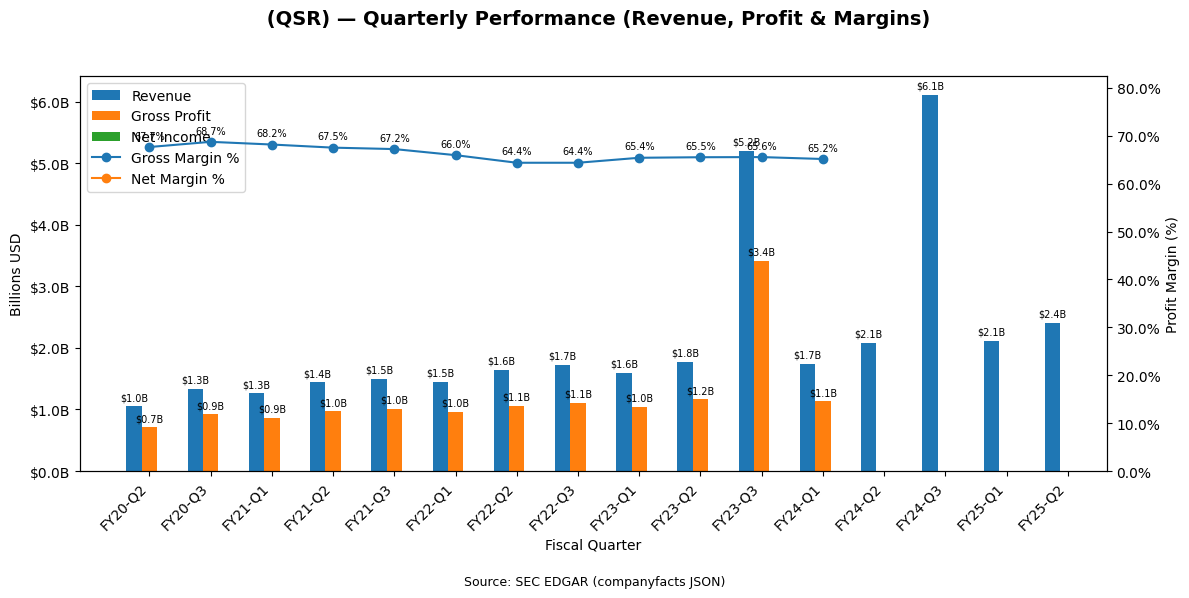

In [28]:
# --- Robust SEC EDGAR quarterly chart (handles missing GrossProfit) ---

import time
from typing import Dict, List
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------- CONFIG ----------
UA = {"User-Agent": "POLITICO / Giulia Petrilli gpetrilli@politico.eu"}
BASE = "https://data.sec.gov/api"

# Tag candidates (in priority order)
REVENUE_TAGS = [
    "RevenueFromContractWithCustomerExcludingAssessedTax",  # ASC-606 "sales"
    "Revenues",
    "SalesRevenueNet"
]
GROSS_PROFIT_TAGS = ["GrossProfit"]  # may be absent
COST_TAGS = [
    "CostOfRevenue",
    "CostOfGoodsAndServicesSold"  # fallback name some filers use
]
NET_INCOME_TAGS = ["NetIncomeLoss"]

# ---------- UTIL / FETCH ----------
def load_ticker_map() -> Dict[str, str]:
    url = "https://www.sec.gov/files/company_tickers.json"
    r = requests.get(url, headers=UA, timeout=30)
    r.raise_for_status()
    j = r.json()
    return {v["ticker"].upper(): f'{int(v["cik_str"]):010d}' for v in j.values()}

def _get_json(url: str):
    r = requests.get(url, headers=UA, timeout=30)
    # handle 404 cleanly—means filer didn't use that tag
    if r.status_code == 404:
        return None
    r.raise_for_status()
    return r.json()

def company_concept(cik10: str, taxonomy: str, tag: str):
    url = f"{BASE}/xbrl/companyconcept/CIK{cik10}/{taxonomy}/{tag}.json"
    return _get_json(url)

def concept_to_df(j: dict, prefer_units=("USD", "USD$", "USD (in millions)")) -> pd.DataFrame:
    if j is None:
        return pd.DataFrame(columns=["fy","fp","end","val"])
    units = j.get("units", {})
    unit_key = None
    for u in prefer_units:
        if u in units:
            unit_key = u
            break
    if unit_key is None and units:
        unit_key = next(iter(units))
    rows = units.get(unit_key, [])
    if not rows:
        return pd.DataFrame(columns=["fy","fp","end","val"])
    df = pd.DataFrame(rows)
    for c in ("fy","fp","end","val"):
        if c not in df.columns: df[c] = pd.NA
    df["fy"] = pd.to_numeric(df["fy"], errors="coerce").astype("Int64")
    df["end"] = pd.to_datetime(df["end"], errors="coerce")
    return df.sort_values(["end","fy"], na_position="last").reset_index(drop=True)[["fy","fp","end","val"]]

def quarterly_series(df: pd.DataFrame) -> pd.DataFrame:
    q = df[df["fp"].str.upper().str.startswith("Q")].copy()
    if q.empty:
        return pd.DataFrame(columns=["fy","fp","end","value"])
    q["qnum"] = q["fp"].str.upper().str.extract(r"Q(\d)").astype("Int64")
    q = (q.sort_values("end")
           .groupby(["fy","qnum"], dropna=True)
           .agg(value=("val","last"), end=("end","last"))
           .reset_index())
    q["fp"] = "Q" + q["qnum"].astype("Int64").astype(str)
    return q[["fy","fp","end","value"]].sort_values(["fy","fp"])

def _fetch_first_available(cik10: str, tags: List[str], label: str = "") -> pd.DataFrame:
    """Try tags in order; return the first non-empty DF and print what was used."""
    for tag in tags:
        j = company_concept(cik10, "us-gaap", tag)
        if j is None:
            continue
        df = concept_to_df(j)
        if not df.empty:
            print(f"[{label}] Using tag: {tag}")
            return df
        time.sleep(0.2)
    print(f"[{label}] No data for tags: {tags}")
    return pd.DataFrame(columns=["fy","fp","end","val"])


def get_quarterly_financials(ticker: str, last_n_quarters: int = 16) -> pd.DataFrame:
    """
    Quarterly Revenue, Gross Profit (tag or derived), Net Income.
    """
    tmap = load_ticker_map()
    tk = ticker.upper()
    if tk not in tmap:
        raise ValueError(f"Ticker {ticker} not in SEC mapping.")
    cik10 = tmap[tk]

    # Revenue
    rev_df = _fetch_first_available(cik10, REVENUE_TAGS)
    rev_q = quarterly_series(rev_df).rename(columns={"value":"revenue"})

    time.sleep(0.2)

# Revenue

    # Gross Profit
    gp_df = _fetch_first_available(cik10, GROSS_PROFIT_TAGS, label="Gross Profit")
    gp_q  = quarterly_series(gp_df).rename(columns={"value":"gross_profit"})
    if gp_q.empty:
        cost_df = _fetch_first_available(cik10, COST_TAGS, label="Cost (for GP derivation)")
        cost_q  = quarterly_series(cost_df).rename(columns={"value":"cost"})
        gp_q = rev_q.merge(cost_q, on=["fy","fp","end"], how="left")
        gp_q["gross_profit"] = gp_q["revenue"] - gp_q["cost"]
        gp_q = gp_q[["fy","fp","end","gross_profit"]]
        print("[Gross Profit] Derived from Revenue – Cost")


    time.sleep(0.2)

    # Net Income
    ni_df = _fetch_first_available(cik10, NET_INCOME_TAGS)
    ni_q  = quarterly_series(ni_df).rename(columns={"value":"net_income"})

    # Combine
    df = rev_q.merge(gp_q, on=["fy","fp","end"], how="outer") \
              .merge(ni_q, on=["fy","fp","end"], how="outer") \
              .sort_values("end").reset_index(drop=True)

    df["gross_margin_pct"] = df["gross_profit"] / df["revenue"]
    df["net_margin_pct"]   = df["net_income"]  / df["revenue"]

    if last_n_quarters:
        df = df.tail(last_n_quarters).reset_index(drop=True)
    return df

# ---------- FORMATTING ----------
def _fmt_billions(x, pos):
    if np.isnan(x): return ""
    return f"${x/1e9:,.1f}B"

def _fmt_pct(x, pos):
    if np.isnan(x): return ""
    return f"{x*100:.1f}%"

# ---------- PLOTTING ----------
def plot_quarterly_performance(qdf: pd.DataFrame, company_name: str, ticker: str,
                               save_path: str = None):
    labels = [f"FY{str(int(fy))[-2:]}-{fp}" for fy, fp in zip(qdf["fy"], qdf["fp"])]
    x = np.arange(len(labels))
    width = 0.25

    fig, ax1 = plt.subplots(figsize=(12, 6))

    b1 = ax1.bar(x - width, qdf["revenue"], width, label="Revenue")
    b2 = ax1.bar(x,          qdf["gross_profit"], width, label="Gross Profit")
    b3 = ax1.bar(x + width,  qdf["net_income"], width, label="Net Income")

    ax1.set_ylabel("Billions USD")
    ax1.set_xlabel("Fiscal Quarter")
    ax1.set_xticks(x, labels, rotation=45, ha="right")
    ax1.yaxis.set_major_formatter(FuncFormatter(_fmt_billions))

    def _annotate(bars):
        for r in bars:
            h = r.get_height()
            if np.isnan(h): continue
            ax1.annotate(f"${h/1e9:,.1f}B",
                         xy=(r.get_x() + r.get_width()/2, h),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha="center", va="bottom", fontsize=7)
    _annotate(b1); _annotate(b2); _annotate(b3)

    ax2 = ax1.twinx()
    l1, = ax2.plot(x, qdf["gross_margin_pct"], marker="o", label="Gross Margin %")
    l2, = ax2.plot(x, qdf["net_margin_pct"], marker="o", label="Net Margin %")
    ax2.set_ylabel("Profit Margin (%)")
    ax2.yaxis.set_major_formatter(FuncFormatter(_fmt_pct))
    ycap = float(np.nanmax(qdf[["gross_margin_pct","net_margin_pct"]].values)) if not qdf.empty else 0.7
    ax2.set_ylim(0, max(0.5, ycap*1.2))

    for xi, yv in enumerate(qdf["gross_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[xi], yv), textcoords="offset points",
                         xytext=(0, 6), ha="center", fontsize=7)
    for xi, yv in enumerate(qdf["net_margin_pct"]):
        if pd.notna(yv):
            ax2.annotate(f"{yv*100:.1f}%", (x[xi], yv), textcoords="offset points",
                         xytext=(0, -12), ha="center", fontsize=7)

    handles = [b1, b2, b3, l1, l2]
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc="upper left")

    fig.suptitle(f"{company_name} ({ticker.upper()}) — Quarterly Performance (Revenue, Profit & Margins)",
                 fontsize=14, fontweight="bold")
    fig.text(0.5, 0.02, "Source: SEC EDGAR (companyfacts JSON)", ha="center", fontsize=9)

    fig.tight_layout(rect=[0, 0.05, 1, 0.95])

    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ---------- EXAMPLE ----------
if __name__ == "__main__":
    TICKER = "QSR"                 # e.g., "MCD", "KO", "QSR"
    COMPANY_NAME = ""
    SAVE_TO = None                 # e.g., "mcd_quarterly.png"

    qdf = get_quarterly_financials(TICKER, last_n_quarters=16)
    print(qdf.tail())
    plot_quarterly_performance(qdf, COMPANY_NAME, TICKER, save_path=SAVE_TO)
